ValueError: cannot reshape array of size 1048576 into shape (512,512)

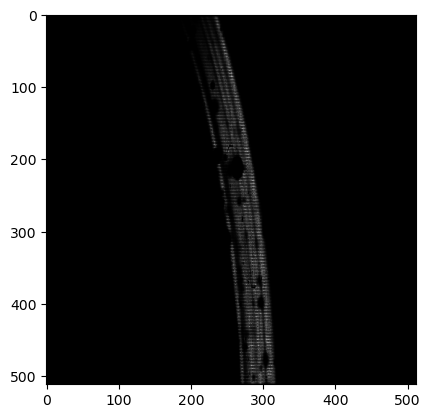

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

rawpath = "C:\\Users\\flow\\Desktop\\20220304_175944_2022-0304-光弾性係数算出_CTABモル比7.6_1[1s]2回目-1min\\2022-0304-光弾性係数算出_CTABモル比7.6_1[1s]2回目-1min.mraw"
width = 512
height = 512
fd = open(rawpath, "rb")

f = np.fromfile(fd, dtype=np.float32, count=height * width)
src = f.reshape((height, width))
fd.close()
plt.imshow(src, cmap="gray")

w = width
h = height

# x_roi, y_roi, w_roi, h_roi の設定（自分で設定）
x_roi = 0  # 例として、x_roi を 100 に設定
y_roi = 0  # 例として、y_roi を 100 に設定
w_roi = 50  # 例として、w_roi を 200 に設定
h_roi = 50  # 例として、h_roi を 200 に設定

PI = 3.14159265358979323846
INF = 1e10
INFI = 10000000000
NaN = -0.00001

# hoseiデータを読み込む関数


def load_hosei_data(filename):
    try:
        with open(filename, "rb") as file:
            data = np.fromfile(file, dtype=np.float32)
            return data
    except IOError:
        print("Error: Failed to read data from", filename)
        return None


# ファイルからデータを読み込む関数
hosei3 = load_hosei_data("hosei3.dat")
hosei6 = load_hosei_data("hosei6.dat")
hosei8 = load_hosei_data("hosei8.dat")

# ここで、hosei3, hosei6, hosei8の形状を変更
if hosei3 is not None:
    hosei3 = hosei3.reshape((height, width))
if hosei6 is not None:
    hosei6 = hosei6.reshape((height, width))
if hosei8 is not None:
    hosei8 = hosei8.reshape((height, width))

if hosei3 is None or hosei6 is None or hosei8 is None:
    # データの読み込みに失敗した場合のエラーハンドリング
    exit(1)
# 読み込みに成功した場合の処理
print("Data loaded successfully.")


# デモザイキングの処理を行う関数
def demosaic(src, w, h):
    dst1 = np.zeros((w, h), dtype=np.float32)
    dst2 = np.zeros((w, h), dtype=np.float32)
    dst3 = np.zeros((w, h), dtype=np.float32)
    dst4 = np.zeros((w, h), dtype=np.float32)

    # 左上画素の処理
    for j in range(h // 2):
        for i in range(w // 2):
            base_index = 2 * i + 2 * j * w
            if i == w // 2 - 1 and j == h // 2 - 1:  # 右下隅
                dst1[base_index: base_index + 2] = src[base_index]
                dst1[base_index + w: base_index + w + 2] = src[base_index]
            elif i == w // 2 - 1:  # 右一列
                dst1[base_index: base_index + 2] = src[base_index]
                dst1[base_index + w] = src[base_index]
                dst1[base_index + w + 1] = (
                    src[base_index] + src[base_index + 2 * w]
                ) / 2
            elif j == h // 2 - 1:  # 下一列
                dst1[base_index] = src[base_index]
                dst1[base_index + 1] = (src[base_index] +
                                        src[base_index + 2]) / 2
                dst1[base_index + w: base_index + w + 2] = src[base_index]
            else:
                dst1[base_index] = src[base_index]
                dst1[base_index + 1] = (src[base_index] +
                                        src[base_index + 2]) / 2
                dst1[base_index + w] = (src[base_index] +
                                        src[base_index + 2 * w]) / 2
                dst1[base_index + w + 1] = (
                    src[base_index]
                    + src[base_index + 2]
                    + src[base_index + 2 * w]
                    + src[base_index + 2 + 2 * w]
                ) / 4

    # 右上画素の処理
    for j in range(h // 2):
        for i in range(w // 2):
            base_index = 2 * i + 1 + 2 * j * w
            if i == 0 and j == h // 2 - 1:  # 左下隅
                dst2[base_index - 1: base_index + 1] = src[base_index]
                dst2[base_index + w - 1: base_index + w + 1] = src[base_index]
            elif i == 0:  # 左一列
                dst2[base_index - 1: base_index + 1] = src[base_index]
                dst2[base_index + w - 1] = src[base_index]
                dst2[base_index + w] = (src[base_index] +
                                        src[base_index + 2 * w]) / 2
            elif j == h // 2 - 1:  # 下一列
                dst2[base_index -
                     1] = (src[base_index - 2] + src[base_index]) / 2
                dst2[base_index] = src[base_index]
                dst2[base_index + w - 1: base_index + w + 1] = src[base_index]
            else:
                dst2[base_index -
                     1] = (src[base_index - 2] + src[base_index]) / 2
                dst2[base_index] = src[base_index]
                dst2[base_index + w - 1] = (
                    src[base_index - 2]
                    + src[base_index]
                    + src[base_index - 2 + 2 * w]
                    + src[base_index + 2 * w]
                ) / 4
                dst2[base_index + w] = (src[base_index] +
                                        src[base_index + 2 * w]) / 2
    # 右下画素の処理
    for j in range(h // 2):
        for i in range(w // 2):
            base_index = 2 * i + 1 + (2 * j + 1) * w
            if i == 0 and j == 0:  # 左上隅
                dst3[base_index - 1 - w: base_index + 1 - w] = src[base_index]
                dst3[base_index - 1: base_index + 1] = src[base_index]
            elif i == 0:  # 左一列
                dst3[base_index - 1 - w] = src[base_index]
                dst3[base_index -
                     w] = (src[base_index - 2 * w] + src[base_index]) / 2
                dst3[base_index - 1] = src[base_index]
                dst3[base_index] = src[base_index]
            elif j == 0:  # 上一列
                dst3[base_index - 1 - w: base_index + 1 - w] = src[base_index]
                dst3[base_index - 1] = src[base_index]
                dst3[base_index] = (src[base_index - 2] + src[base_index]) / 2
            else:
                dst3[base_index - 1 - w] = (
                    src[base_index - 2 - 2 * w]
                    + src[base_index - 2 * w]
                    + src[base_index - 2]
                    + src[base_index]
                ) / 4
                dst3[base_index -
                     w] = (src[base_index - 2 * w] + src[base_index]) / 2
                dst3[base_index -
                     1] = (src[base_index - 2] + src[base_index]) / 2
                dst3[base_index] = src[base_index]

    # 左下画素の処理
    for j in range(h // 2):
        for i in range(w // 2):
            base_index = 2 * i + (2 * j + 1) * w
            if i == w // 2 - 1 and j == 0:  # 右上隅
                dst4[base_index: base_index + 2] = src[base_index + 1]
                dst4[base_index + w: base_index + w + 2] = src[base_index + 1]
            elif i == w // 2 - 1:  # 右一列
                dst4[base_index] = (src[base_index + 1] +
                                    src[base_index - 1]) / 2
                dst4[base_index + 1] = src[base_index + 1]
                dst4[base_index + w: base_index + w + 2] = src[base_index + 1]
            elif j == 0:  # 上一列
                dst4[base_index: base_index + 2] = src[base_index + 1]
                dst4[base_index + w] = src[base_index + 1]
                dst4[base_index + w + 1] = (
                    src[base_index + 1] + src[base_index + 3]
                ) / 2
            else:
                dst4[base_index] = (src[base_index + 1] +
                                    src[base_index - 1]) / 2
                dst4[base_index + 1] = (
                    src[base_index + 1]
                    + src[base_index - 1]
                    + src[base_index + 3]
                    + src[base_index + 1 - 2 * w]
                ) / 4
                dst4[base_index + w] = (src[base_index + 1] +
                                        src[base_index - 1]) / 2
                dst4[base_index + w + 1] = src[base_index + 1]

    return dst1, dst2, dst3, dst4


def calc_stokes_for_P(src, w, h, x_roi, y_roi, w_roi, h_roi, hosei3, hosei6, hosei8):
    # 暗出力補正
    if hosei3 is not None:
        _src = src - hosei3
    else:
        _src = np.copy(src)

    # デモザイキング
    dst1, dst2, dst3, dst4 = demosaic(_src, w, h)

    # ストークスパラメータの計算用配列の初期化
    s0_ref = np.zeros((4 * w_roi * h_roi,))
    s1_ref = np.zeros((4 * w_roi * h_roi,))
    s2_ref = np.zeros((4 * w_roi * h_roi,))
    s3_ref = np.zeros((4 * w_roi * h_roi,))

    # ストークスパラメータの計算
    for y in range(h):
        for x in range(w):
            pos = x + 2 * x_roi + (y + 2 * y_roi) * w
            _s0 = sum(dst1[pos] * hosei8[12 * pos + i] for i in range(4))
            _s1 = sum(dst1[pos] * hosei8[12 * pos + 4 + i] for i in range(4))
            _s2 = sum(dst1[pos] * hosei8[12 * pos + 8 + i] for i in range(4))

            val = _s0**2 - _s1**2 - _s2**2
            _s3 = np.sqrt(val) if val > 0 else 0.0

            indices = [12 * pos + i for i in range(12)]
            corrections = [hosei6[4 * pos + i] for i in range(4)]
            _s0 = sum(
                (dst1[pos] - _s3 * corrections[i]) * hosei8[indices[i]]
                for i in range(4)
            )
            _s1 = sum(
                (dst1[pos] - _s3 * corrections[i]) * hosei8[indices[4 + i]]
                for i in range(4)
            )
            _s2 = sum(
                (dst1[pos] - _s3 * corrections[i]) * hosei8[indices[8 + i]]
                for i in range(4)
            )

            val = _s0**2 - _s1**2 - _s2**2
            _s3 = np.sqrt(val) if val > 0 else 0.0

            idx = x // 2 + (y // 2) * w_roi
            s0_ref[idx] = _s0
            s1_ref[idx] = _s1 / _s0 if _s0 != 0 else 0
            s2_ref[idx] = _s2 / _s0 if _s0 != 0 else 0
            s3_ref[idx] = _s3 / _s0 if _s0 != 0 else 0

    # ROI内のデータの平均計算
    s0 = np.mean(s0_ref.reshape((h_roi, w_roi, 4)), axis=2)
    s1 = np.mean(s1_ref.reshape((h_roi, w_roi, 4)), axis=2)
    s2 = np.mean(s2_ref.reshape((h_roi, w_roi, 4)), axis=2)
    s3 = np.mean(s3_ref.reshape((h_roi, w_roi, 4)), axis=2)

    return s0, s1, s2, s3


# calc_stokes_for_P の結果を表示
s0, s1, s2, s3 = calc_stokes_for_P(
    src, w, h, x_roi, y_roi, w_roi, h_roi, hosei3, hosei6, hosei8
)

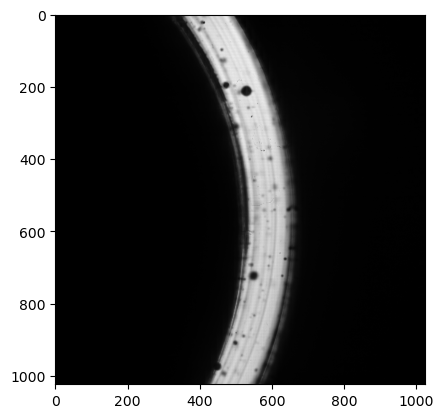

ValueError: operands could not be broadcast together with shapes (1024,) (4096,) 

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def load_hosei_data(filename, shape):
    try:
        with open(filename, 'rb') as file:
            data = np.fromfile(file, dtype=np.float32)
            return data.reshape(shape)
    except IOError as e:
        print(f"Error: Failed to read data from {filename}. Error: {e}")
        return None


def demosaic(src, w, h):
    # dst1, dst2, dst3, dst4の初期化
    dst1 = np.zeros_like(src)
    dst2 = np.zeros_like(src)
    dst3 = np.zeros_like(src)
    dst4 = np.zeros_like(src)

    # 左上画素（dst1）の処理
    for j in range(h // 2):
        for i in range(w // 2):
            if i == w // 2 - 1 and j == h // 2 - 1:  # 右下隅
                dst1[2*i:2*i+2, 2*j:2*j+2] = src[2*i, 2*j]
            elif i == w // 2 - 1:  # 右一列
                dst1[2*i, 2*j] = src[2*i, 2*j]
                dst1[2*i+1, 2*j] = src[2*i, 2*j]
                dst1[2*i+1, 2*j+1] = src[2*i, 2*j]
                dst1[2*i, 2*j+1] = (src[2*i, 2*j] + src[2*i, 2*j+2]) / 2
            elif j == h // 2 - 1:  # 下一列
                dst1[2*i, 2*j] = src[2*i, 2*j]
                dst1[2*i+1, 2*j] = (src[2*i, 2*j] + src[2*i+2, 2*j]) / 2
                dst1[2*i+1, 2*j+1] = src[2*i, 2*j]
                dst1[2*i, 2*j+1] = src[2*i, 2*j]
            else:
                dst1[2*i, 2*j] = src[2*i, 2*j]
                dst1[2*i+1, 2*j] = (src[2*i, 2*j] + src[2*i+2, 2*j]) / 2
                dst1[2*i+1, 2*j+1] = (src[2*i, 2*j] + src[2*i+2, 2*j] + src[2*i, 2*j+2] + src[2*i+2, 2*j+2]) / 4
                dst1[2*i, 2*j+1] = (src[2*i, 2*j] + src[2*i, 2*j+2]) / 2

    # 右上画素（dst2）の処理
    for j in range(h // 2):
        for i in range(w // 2):
            if i == 0 and j == h // 2 - 1:  # 左下隅
                dst2[2*i:2*i+2, 2*j:2*j+2] = src[2*i+1, 2*j]
            elif i == 0:  # 左一列
                dst2[2*i, 2*j] = src[2*i+1, 2*j]
                dst2[2*i+1, 2*j] = src[2*i+1, 2*j]
                dst2[2*i+1, 2*j+1] = (src[2*i+1, 2*j] + src[2*i+1, 2*j+2]) / 2
                dst2[2*i, 2*j+1] = src[2*i+1, 2*j]
            elif j == h // 2 - 1:  # 下一列
                dst2[2*i, 2*j] = (src[2*i-1, 2*j] + src[2*i+1, 2*j]) / 2
                dst2[2*i+1, 2*j] = src[2*i+1, 2*j]
                dst2[2*i+1, 2*j+1] = src[2*i+1, 2*j]
                dst2[2*i, 2*j+1] = src[2*i+1, 2*j]
            else:
                dst2[2*i, 2*j] = (src[2*i-1, 2*j] + src[2*i+1, 2*j]) / 2
                dst2[2*i+1, 2*j] = src[2*i+1, 2*j]
                dst2[2*i+1, 2*j+1] = (src[2*i+1, 2*j] + src[2*i+1, 2*j+2]) / 2
                dst2[2*i, 2*j+1] = (src[2*i-1, 2*j] + src[2*i+1, 2*j] + src[2*i-1, 2*j+2] + src[2*i+1, 2*j+2]) / 4
    
    # 右下画素（dst3）の処理
    for j in range(h // 2):
        for i in range(w // 2):
            if i == 0 and j == 0:  # 左上隅
                dst3[2*i:2*i+2, 2*j:2*j+2] = src[2*i+1, 2*j+1]
            elif i == 0:  # 左一列
                dst3[2*i, 2*j] = src[2*i+1, 2*j+1]
                dst3[2*i+1, 2*j] = (src[2*i+1, 2*j-1] + src[2*i+1, 2*j+1]) / 2
                dst3[2*i+1, 2*j+1] = src[2*i+1, 2*j+1]
                dst3[2*i, 2*j+1] = src[2*i+1, 2*j+1]
            elif j == 0:  # 上一列
                dst3[2*i, 2*j] = src[2*i+1, 2*j+1]
                dst3[2*i+1, 2*j] = src[2*i+1, 2*j+1]
                dst3[2*i+1, 2*j+1] = src[2*i+1, 2*j+1]
                dst3[2*i, 2*j+1] = (src[2*i-1, 2*j+1] + src[2*i+1, 2*j+1]) / 2
            else:
                dst3[2*i, 2*j] = (src[2*i-1, 2*j-1] + src[2*i+1, 2*j-1] + src[2*i-1, 2*j+1] + src[2*i+1, 2*j+1]) / 4
                dst3[2*i+1, 2*j] = (src[2*i+1, 2*j-1] + src[2*i+1, 2*j+1]) / 2
                dst3[2*i+1, 2*j+1] = src[2*i+1, 2*j+1]
                dst3[2*i, 2*j+1] = (src[2*i-1, 2*j+1] + src[2*i+1, 2*j+1]) / 2
    
    # 左下画素（dst4）の処理
    for j in range(h // 2):
        for i in range(w // 2):
            if i == w // 2 - 1 and j == 0:  # 右上隅
                dst4[2*i:2*i+2, 2*j:2*j+2] = src[2*i, 2*j+1]
            elif i == w // 2 - 1:  # 右一列
                dst4[2*i, 2*j] = (src[2*i, 2*j+1] + src[2*i, 2*j-1]) / 2
                dst4[2*i+1, 2*j] = src[2*i, 2*j+1]
                dst4[2*i+1, 2*j+1] = src[2*i, 2*j+1]
                dst4[2*i, 2*j+1] = src[2*i, 2*j+1]
            elif j == 0:  # 上一列
                dst4[2*i, 2*j] = src[2*i, 2*j+1]
                dst4[2*i+1, 2*j] = src[2*i, 2*j+1]
                dst4[2*i+1, 2*j+1] = (src[2*i, 2*j+1] + src[2*i+2, 2*j+1]) / 2
                dst4[2*i, 2*j+1] = src[2*i, 2*j+1]
            else:
                dst4[2*i, 2*j] = (src[2*i, 2*j+1] + src[2*i, 2*j-1]) / 2
                dst4[2*i+1, 2*j] = (src[2*i, 2*j+1] + src[2*i, 2*j-1] + src[2*i+2, 2*j+1] + src[2*i+2, 2*j-1]) / 4
                dst4[2*i+1, 2*j+1] = (src[2*i, 2*j+1] + src[2*i+2, 2*j+1]) / 2
                dst4[2*i, 2*j+1] = src[2*i, 2*j+1]

        return dst1, dst2, dst3, dst4

def calc_stokes_for_P(src, w, h, x_roi, y_roi, w_roi, h_roi, hosei3, hosei6, hosei8):
    # デモザイキング
    dst1, dst2, dst3, dst4 = demosaic(src, w, h)

    # 暗出力補正
    if hosei3 is not None:
        _src = src - hosei3
    else:
        _src = np.copy(src)

    # ストークスパラメータの計算
    s0_ref = np.zeros((h, w))
    s1_ref = np.zeros((h, w))
    s2_ref = np.zeros((h, w))
    s3_ref = np.zeros((h, w))

    for y in range(h):
        for x in range(w):
            pos = x + y * w

            # パラメータ計算用の中間値
            _s0 = (dst1[pos] * hosei8[12*pos] + dst2[pos] * hosei8[12*pos + 1] +
                dst3[pos] * hosei8[12*pos + 2] + dst4[pos] * hosei8[12*pos + 3])
            _s1 = (dst1[pos] * hosei8[12*pos + 4] + dst2[pos] * hosei8[12*pos + 5] +
                dst3[pos] * hosei8[12*pos + 6] + dst4[pos] * hosei8[12*pos + 7])
            _s2 = (dst1[pos] * hosei8[12*pos + 8] + dst2[pos] * hosei8[12*pos + 9] +
                dst3[pos] * hosei8[12*pos + 10] + dst4[pos] * hosei8[12*pos + 11])

            # _s3の計算
            val = _s0**2 - _s1**2 - _s2**2
            _s3 = np.sqrt(val) if val > 0 else 0.0

            # 再計算
            _s0 = ((dst1[pos] - _s3 * hosei6[4*pos]) * hosei8[12*pos] +
                (dst2[pos] - _s3 * hosei6[4*pos + 1]) * hosei8[12*pos + 1] +
                (dst3[pos] - _s3 * hosei6[4*pos + 2]) * hosei8[12*pos + 2] +
                (dst4[pos] - _s3 * hosei6[4*pos + 3]) * hosei8[12*pos + 3])
            _s1 = ((dst1[pos] - _s3 * hosei6[4*pos]) * hosei8[12*pos + 4] +
                (dst2[pos] - _s3 * hosei6[4*pos + 1]) * hosei8[12*pos + 5] +
                (dst3[pos] - _s3 * hosei6[4*pos + 2]) * hosei8[12*pos + 6] +
                (dst4[pos] - _s3 * hosei6[4*pos + 3]) * hosei8[12*pos + 7])
            _s2 = ((dst1[pos] - _s3 * hosei6[4*pos]) * hosei8[12*pos + 8] +
                (dst2[pos] - _s3 * hosei6[4*pos + 1]) * hosei8[12*pos + 9] +
                (dst3[pos] - _s3 * hosei6[4*pos + 2]) * hosei8[12*pos + 10] +
                (dst4[pos] - _s3 * hosei6[4*pos + 3]) * hosei8[12*pos + 11])

            val = _s0**2 - _s1**2 - _s2**2
            _s3 = np.sqrt(val) if val > 0 else 0.0

            # ストークスパラメータの格納
            s0_ref[y, x] = _s0
            s1_ref[y, x] = _s1 / _s0
            s2_ref[y, x] = _s2 / _s0
            s3_ref[y, x] = _s3 / _s0

    # ROIに基づく最終ストークスパラメータの計算
    s0 = np.mean(s0_ref[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi])
    s1 = np.mean(s1_ref[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi])
    s2 = np.mean(s2_ref[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi])
    s3 = np.mean(s3_ref[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi])

    return s0, s1, s2, s3

# 補正ファイルの形状を決定する
shape3 = (1024, 1024)  # hosei3.dat の形状
shape6 = (2048, 2048)  # hosei6.dat の形状
shape8 = (3072, 4096)  # hosei8.dat の形状

# 補正データを読み込む
hosei3 = load_hosei_data('hosei3.dat', shape3)
hosei6 = load_hosei_data('hosei6.dat', shape6)
hosei8 = load_hosei_data('hosei8.dat', shape8)

# 画像の読み込み
rawpath = "C:\\Users\\flow\\Desktop\\20220304_175944_2022-0304-光弾性係数算出_CTABモル比7.6_1[1s]2回目-1min\\2022-0304-光弾性係数算出_CTABモル比7.6_1[1s]2回目-1min.mraw"
width, height = 1024, 1024
with open(rawpath, 'rb') as file:
    f = np.fromfile(file, dtype=np.uint16, count=width * height)
    img = (f & 0xFFF) / 0xFFF
    img = img.reshape((height, width))

# 画像を表示
plt.imshow(img, cmap="gray")
plt.show()
# 画像の保存
base_path= "C:\\Users\\flow\\Desktop\\bubble_rasing_result\\"
plt.imsave(base_path+"img.png", img, cmap="gray")             

# ストークスパラメータの計算
x_roi, y_roi, w_roi, h_roi = 0, 0, 512, 512  # ROIの設定
s0, s1, s2, s3 = calc_stokes_for_P(img, width, height, x_roi, y_roi, w_roi, h_roi, hosei3, hosei6, hosei8)

# ストークスパラメータの表示
print(f"s0: {s0}, s1: {s1}, s2: {s2}, s3: {s3}")


hosei3_data shape: (1024, 1024)
hosei6_data shape: (4096, 1024)
hosei8_data shape: (12288, 1024)


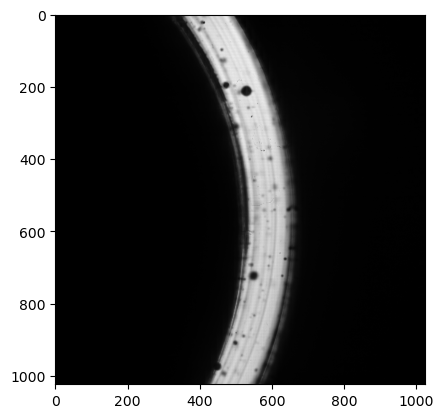

IndexError: index 12 is out of bounds for axis 0 with size 12

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def load_hosei_data(filename, num_layers):
    try:
        with open(filename, 'rb') as file:
            data = np.fromfile(file, dtype=np.int32)
            if num_layers == 1:
                # 単層データの場合
                return data.reshape((int(np.sqrt(data.size)), int(np.sqrt(data.size))))
            else:
                # 多層データの場合
                size_per_layer = data.size // num_layers
                reshaped_data = data.reshape((num_layers, int(np.sqrt(size_per_layer)), int(np.sqrt(size_per_layer))))
                # すべての層を2次元配列に連結
                return reshaped_data.reshape((-1, int(np.sqrt(size_per_layer))))
    except IOError as e:
        print(f"Error: Failed to read data from {filename}. Error: {e}")
        return None

# 補正データファイルのパスを定義（適宜変更してください）
path_hosei3 = 'C:\\Users\\flow\\Desktop\\konprogram\\polarization\\hosei3.dat'
path_hosei6 = 'C:\\Users\\flow\\Desktop\\konprogram\\polarization\\hosei6.dat'
path_hosei8 = 'C:\\Users\\flow\\Desktop\\konprogram\\polarization\\hosei8.dat'

# 補正データを読み込む
hosei3_data = load_hosei_data(path_hosei3, 1)  # hosei3.datは1層のデータ
hosei6_data = load_hosei_data(path_hosei6, 4)  # hosei6.datは4層のデータ
hosei8_data = load_hosei_data(path_hosei8, 12) # hosei8.datは12層のデータ

# 読み込んだデータの確認
print("hosei3_data shape:", hosei3_data.shape)
print("hosei6_data shape:", hosei6_data.shape)
print("hosei8_data shape:", hosei8_data.shape)



def demosaic(src, w, h):
    # dst1, dst2, dst3, dst4の初期化
    dst1 = np.zeros_like(src)
    dst2 = np.zeros_like(src)
    dst3 = np.zeros_like(src)
    dst4 = np.zeros_like(src)

    # 左上画素（dst1）の処理
    for j in range(h // 2):
        for i in range(w // 2):
            if i == w // 2 - 1 and j == h // 2 - 1:  # 右下隅
                dst1[2*i:2*i+2, 2*j:2*j+2] = src[2*i, 2*j]
            elif i == w // 2 - 1:  # 右一列
                dst1[2*i, 2*j] = src[2*i, 2*j]
                dst1[2*i+1, 2*j] = src[2*i, 2*j]
                dst1[2*i+1, 2*j+1] = src[2*i, 2*j]
                dst1[2*i, 2*j+1] = (src[2*i, 2*j] + src[2*i, 2*j+2]) / 2
            elif j == h // 2 - 1:  # 下一列
                dst1[2*i, 2*j] = src[2*i, 2*j]
                dst1[2*i+1, 2*j] = (src[2*i, 2*j] + src[2*i+2, 2*j]) / 2
                dst1[2*i+1, 2*j+1] = src[2*i, 2*j]
                dst1[2*i, 2*j+1] = src[2*i, 2*j]
            else:
                dst1[2*i, 2*j] = src[2*i, 2*j]
                dst1[2*i+1, 2*j] = (src[2*i, 2*j] + src[2*i+2, 2*j]) / 2
                dst1[2*i+1, 2*j+1] = (src[2*i, 2*j] + src[2*i+2, 2*j] + src[2*i, 2*j+2] + src[2*i+2, 2*j+2]) / 4
                dst1[2*i, 2*j+1] = (src[2*i, 2*j] + src[2*i, 2*j+2]) / 2

    # 右上画素（dst2）の処理
    for j in range(h // 2):
        for i in range(w // 2):
            if i == 0 and j == h // 2 - 1:  # 左下隅
                dst2[2*i:2*i+2, 2*j:2*j+2] = src[2*i+1, 2*j]
            elif i == 0:  # 左一列
                dst2[2*i, 2*j] = src[2*i+1, 2*j]
                dst2[2*i+1, 2*j] = src[2*i+1, 2*j]
                dst2[2*i+1, 2*j+1] = (src[2*i+1, 2*j] + src[2*i+1, 2*j+2]) / 2
                dst2[2*i, 2*j+1] = src[2*i+1, 2*j]
            elif j == h // 2 - 1:  # 下一列
                dst2[2*i, 2*j] = (src[2*i-1, 2*j] + src[2*i+1, 2*j]) / 2
                dst2[2*i+1, 2*j] = src[2*i+1, 2*j]
                dst2[2*i+1, 2*j+1] = src[2*i+1, 2*j]
                dst2[2*i, 2*j+1] = src[2*i+1, 2*j]
            else:
                dst2[2*i, 2*j] = (src[2*i-1, 2*j] + src[2*i+1, 2*j]) / 2
                dst2[2*i+1, 2*j] = src[2*i+1, 2*j]
                dst2[2*i+1, 2*j+1] = (src[2*i+1, 2*j] + src[2*i+1, 2*j+2]) / 2
                dst2[2*i, 2*j+1] = (src[2*i-1, 2*j] + src[2*i+1, 2*j] + src[2*i-1, 2*j+2] + src[2*i+1, 2*j+2]) / 4
    
    # 右下画素（dst3）の処理
    for j in range(h // 2):
        for i in range(w // 2):
            if i == 0 and j == 0:  # 左上隅
                dst3[2*i:2*i+2, 2*j:2*j+2] = src[2*i+1, 2*j+1]
            elif i == 0:  # 左一列
                dst3[2*i, 2*j] = src[2*i+1, 2*j+1]
                dst3[2*i+1, 2*j] = (src[2*i+1, 2*j-1] + src[2*i+1, 2*j+1]) / 2
                dst3[2*i+1, 2*j+1] = src[2*i+1, 2*j+1]
                dst3[2*i, 2*j+1] = src[2*i+1, 2*j+1]
            elif j == 0:  # 上一列
                dst3[2*i, 2*j] = src[2*i+1, 2*j+1]
                dst3[2*i+1, 2*j] = src[2*i+1, 2*j+1]
                dst3[2*i+1, 2*j+1] = src[2*i+1, 2*j+1]
                dst3[2*i, 2*j+1] = (src[2*i-1, 2*j+1] + src[2*i+1, 2*j+1]) / 2
            else:
                dst3[2*i, 2*j] = (src[2*i-1, 2*j-1] + src[2*i+1, 2*j-1] + src[2*i-1, 2*j+1] + src[2*i+1, 2*j+1]) / 4
                dst3[2*i+1, 2*j] = (src[2*i+1, 2*j-1] + src[2*i+1, 2*j+1]) / 2
                dst3[2*i+1, 2*j+1] = src[2*i+1, 2*j+1]
                dst3[2*i, 2*j+1] = (src[2*i-1, 2*j+1] + src[2*i+1, 2*j+1]) / 2
    
    # 左下画素（dst4）の処理
    for j in range(h // 2):
        for i in range(w // 2):
            if i == w // 2 - 1 and j == 0:  # 右上隅
                dst4[2*i:2*i+2, 2*j:2*j+2] = src[2*i, 2*j+1]
            elif i == w // 2 - 1:  # 右一列
                dst4[2*i, 2*j] = (src[2*i, 2*j+1] + src[2*i, 2*j-1]) / 2
                dst4[2*i+1, 2*j] = src[2*i, 2*j+1]
                dst4[2*i+1, 2*j+1] = src[2*i, 2*j+1]
                dst4[2*i, 2*j+1] = src[2*i, 2*j+1]
            elif j == 0:  # 上一列
                dst4[2*i, 2*j] = src[2*i, 2*j+1]
                dst4[2*i+1, 2*j] = src[2*i, 2*j+1]
                dst4[2*i+1, 2*j+1] = (src[2*i, 2*j+1] + src[2*i+2, 2*j+1]) / 2
                dst4[2*i, 2*j+1] = src[2*i, 2*j+1]
            else:
                dst4[2*i, 2*j] = (src[2*i, 2*j+1] + src[2*i, 2*j-1]) / 2
                dst4[2*i+1, 2*j] = (src[2*i, 2*j+1] + src[2*i, 2*j-1] + src[2*i+2, 2*j+1] + src[2*i+2, 2*j-1]) / 4
                dst4[2*i+1, 2*j+1] = (src[2*i, 2*j+1] + src[2*i+2, 2*j+1]) / 2
                dst4[2*i, 2*j+1] = src[2*i, 2*j+1]

        return dst1, dst2, dst3, dst4


def calc_stokes_for_P(src, w, h, x_roi, y_roi, w_roi, h_roi, hosei3, hosei6, hosei8):
    dst1, dst2, dst3, dst4 = demosaic(src, w, h)

    if hosei3 is not None:
        _src = src - hosei3
    else:
        _src = np.copy(src)

    s0_ref = np.zeros((h, w))
    s1_ref = np.zeros((h, w))
    s2_ref = np.zeros((h, w))
    s3_ref = np.zeros((h, w))

    for y in range(h):
        for x in range(w):
            pos_hosei = (x + 2 * x_roi) + (y + 2 * y_roi) * w

            # _s0, _s1, _s2の初回計算
            _s0 = (dst1[y, x] * hosei8[0, pos_hosei] + dst2[y, x] * hosei8[1, pos_hosei] +
                dst3[y, x] * hosei8[2, pos_hosei] + dst4[y, x] * hosei8[3, pos_hosei])
            _s1 = (dst1[y, x] * hosei8[4, pos_hosei] + dst2[y, x] * hosei8[5, pos_hosei] +
                dst3[y, x] * hosei8[6, pos_hosei] + dst4[y, x] * hosei8[7, pos_hosei])
            _s2 = (dst1[y, x] * hosei8[8, pos_hosei] + dst2[y, x] * hosei8[9, pos_hosei] +
                dst3[y, x] * hosei8[10, pos_hosei] + dst4[y, x] * hosei8[11, pos_hosei])
            # _s3の計算
            val = _s0**2 - _s1**2 - _s2**2
            _s3 = np.sqrt(np.where(val > 0, val, 0))

            # _s0, _s1, _s2の再計算
            _s0 = sum((dst[y, x] - _s3 * hosei6[j, y, x]) * hosei8[3*i + j, y, x] for i, dst in enumerate([dst1, dst2, dst3, dst4]) for j in range(3))
            _s1 = sum((dst[y, x] - _s3 * hosei6[j, y, x]) * hosei8[3*i + j + 1, y, x] for i, dst in enumerate([dst1, dst2, dst3, dst4]) for j in range(3))
            _s2 = sum((dst[y, x] - _s3 * hosei6[j, y, x]) * hosei8[3*i + j + 2, y, x] for i, dst in enumerate([dst1, dst2, dst3, dst4]) for j in range(3))




            # _s3の再計算
            val = _s0**2 - _s1**2 - _s2**2
            _s3 = np.sqrt(np.where(val > 0, val, 0))

            # ストークスパラメータの格納
            s0_ref[y, x] = _s0
            s1_ref[y, x] = _s1 / _s0
            s2_ref[y, x] = _s2 / _s0
            s3_ref[y, x] = _s3 / _s0

    # ROIに基づく最終ストークスパラメータの計算
    s0 = np.mean(s0_ref[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi])
    s1 = np.mean(s1_ref[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi])
    s2 = np.mean(s2_ref[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi])
    s3 = np.mean(s3_ref[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi])

    return s0, s1, s2, s3

# 画像の読み込み
rawpath = "C:\\Users\\flow\\Desktop\\20220304_175944_2022-0304-光弾性係数算出_CTABモル比7.6_1[1s]2回目-1min\\2022-0304-光弾性係数算出_CTABモル比7.6_1[1s]2回目-1min.mraw"
width, height = 1024, 1024
with open(rawpath, 'rb') as file:
    f = np.fromfile(file, dtype=np.uint16, count=width * height)
    img = (f & 0xFFF) / 0xFFF
    img = img.reshape((height, width))

# 画像を表示
plt.imshow(img, cmap="gray")
plt.show()

# ストークスパラメータの計算
x_roi, y_roi, w_roi, h_roi = 0, 0, 512, 512  # ROIの設定
s0, s1, s2, s3 = calc_stokes_for_P(img, width, height, x_roi, y_roi, w_roi, h_roi, hosei3, hosei6, hosei8)

# ストークスパラメータの表示
print(f"s0: {s0}, s1: {s1}, s2: {s2}, s3: {s3}")


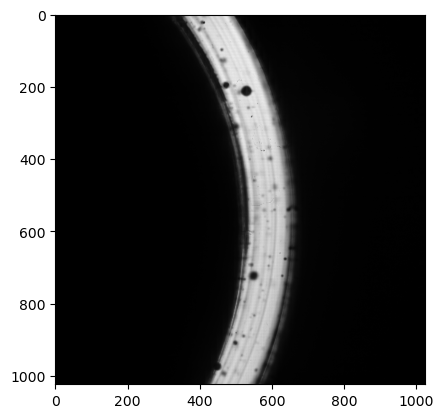

IndexError: index 1048576 is out of bounds for axis 0 with size 1048576

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 画像の読み込みと2次元化
rawpath = "C:\\Users\\flow\\Desktop\\20220304_175944_2022-0304-光弾性係数算出_CTABモル比7.6_1[1s]2回目-1min\\2022-0304-光弾性係数算出_CTABモル比7.6_1[1s]2回目-1min.mraw"
width, height = 1024, 1024
with open(rawpath, 'rb') as file:
    f = np.fromfile(file, dtype=np.uint16, count=width * height)
    img = (f & 0xFFF) / 0xFFF
    img = img.reshape((height, width))

# 画像を表示
plt.imshow(img, cmap="gray")
plt.show()
# 画像の保存
base_path= "C:\\Users\\flow\\Desktop\\bubble_rasing_result\\"
plt.imsave(base_path+"img.png", img, cmap="gray") 

# 2次元配列を1次元配列に変換
img_flattened = img.flatten()

def demosaic(img_flattened, w, h):
    # 各領域のデータを格納するための配列を初期化
    dst1 = np.zeros_like(img_flattened)
    dst2 = np.zeros_like(img_flattened)
    dst3 = np.zeros_like(img_flattened)
    dst4 = np.zeros_like(img_flattened)
    
    
#左上
    for j in range(h // 2):
        for i in range(w // 2):
            pos = 2 * i + 2 * j * w
            if i == w // 2 - 1 and j == h // 2 - 1:
                # 右下隅
                dst1[pos] = img_flattened[pos]
                dst1[pos + 1] = img_flattened[pos]
                dst1[pos + w] = img_flattened[pos]
                dst1[pos + w + 1] = img_flattened[pos]
            elif i == w // 2 - 1:
                # 右一列
                dst1[pos] = img_flattened[pos]
                dst1[pos + 1] = img_flattened[pos]
                dst1[pos + w] = img_flattened[pos]
                dst1[pos + w + 1] = (img_flattened[pos] + img_flattened[pos + 2 * w]) / 2
            elif j == h // 2 - 1:
                # 下一列
                dst1[pos] = img_flattened[pos]
                dst1[pos + 1] = (img_flattened[pos] + img_flattened[pos + 2]) / 2
                dst1[pos + w] = img_flattened[pos]
                dst1[pos + w + 1] = img_flattened[pos]
            else:
                # 通常の画素
                dst1[pos] = img_flattened[pos]
                dst1[pos + 1] = (img_flattened[pos] + img_flattened[pos + 2]) / 2
                dst1[pos + w] = (img_flattened[pos] + img_flattened[pos + 2 * w]) / 2
                dst1[pos + w + 1] = (img_flattened[pos] + img_flattened[pos + 2] + img_flattened[pos + 2 * w] + img_flattened[pos + 2 + 2 * w]) / 4

#右上
    for j in range(h // 2):
        for i in range(w // 2):
            pos = 2 * i + 1 + 2 * j * w
            if i == 0 and j == h // 2 - 1:
                # 左下隅
                dst2[pos - 1] = img_flattened[pos]
                dst2[pos] = img_flattened[pos]
                dst2[pos + w] = img_flattened[pos]
                dst2[pos + w - 1] = img_flattened[pos]
            elif i == 0:
                # 左一列
                dst2[pos - 1] = img_flattened[pos]
                dst2[pos] = img_flattened[pos]
                dst2[pos + w] = (img_flattened[pos] + img_flattened[pos + 2 * w]) / 2
                dst2[pos + w - 1] = img_flattened[pos]
            elif j == h // 2 - 1:
                # 下一列
                dst2[pos - 1] = (img_flattened[pos - 2] + img_flattened[pos]) / 2
                dst2[pos] = img_flattened[pos]
                dst2[pos + w] = img_flattened[pos]
                dst2[pos + w - 1] = img_flattened[pos]
            else:
                # 通常の画素
                dst2[pos - 1] = (img_flattened[pos - 2] + img_flattened[pos]) / 2
                dst2[pos] = img_flattened[pos]
                dst2[pos + w] = (img_flattened[pos] + img_flattened[pos + 2 * w]) / 2
                dst2[pos + w - 1] = (img_flattened[pos - 2] + img_flattened[pos] + img_flattened[pos - 2 + 2 * w] + img_flattened[pos + 2 * w]) / 4
                
#右下
    for j in range(h // 2):
        for i in range(w // 2):
            pos = 2 * i + 1 + (2 * j + 1) * w
            # インデックスが配列の範囲内にあることを確認
            if pos - 1 >= 0 and pos - 1 < len(img_flattened):
            # 左上隅の処理
                if i == 0 and j == 0:
                    dst3[pos - w - 1] = img_flattened[pos]
                    dst3[pos - w] = (img_flattened[pos - w - 1] + img_flattened[pos - w + 1]) / 2
                    dst3[pos - 1] = (img_flattened[pos - w - 1] + img_flattened[pos + w - 1]) / 2
                    dst3[pos] = (img_flattened[pos - w - 1] + img_flattened[pos - w + 1] + img_flattened[pos + w - 1] + img_flattened[pos + w + 1]) / 4
                # 左一列の処理
                elif i == 0:
                    dst3[pos - w - 1] = (img_flattened[pos - w - 1] + img_flattened[pos - w + 1]) / 2
                    dst3[pos - w] = img_flattened[pos - w]
                    dst3[pos - 1] = (img_flattened[pos - w - 1] + img_flattened[pos + w - 1]) / 2
                    dst3[pos] = (img_flattened[pos - w - 1] + img_flattened[pos - w + 1] + img_flattened[pos + w - 1] + img_flattened[pos + w + 1]) / 4
                # 上一列の処理
                elif j == 0:
                    dst3[pos - w - 1] = (img_flattened[pos - w - 1] + img_flattened[pos - w + 1]) / 2
                    dst3[pos - w] = img_flattened[pos - w]
                    dst3[pos - 1] = (img_flattened[pos - w - 1] + img_flattened[pos + w - 1]) / 2
                    dst3[pos] = (img_flattened[pos - w - 1] + img_flattened[pos - w + 1] + img_flattened[pos + w - 1] + img_flattened[pos + w + 1]) / 4
                # 通常の画素の処理
                else:
                    dst3[pos - w - 1] = (img_flattened[pos - w - 1] + img_flattened[pos - w + 1]) / 2
                    dst3[pos - w] = img_flattened[pos - w]
                    dst3[pos - 1] = (img_flattened[pos - w - 1] + img_flattened[pos + w - 1]) / 2
                    dst3[pos] = (img_flattened[pos - w - 1] + img_flattened[pos - w + 1] + img_flattened[pos + w - 1] + img_flattened[pos + w + 1]) / 4

# 左下
    for j in range(h // 2):
        for i in range(w // 2):
            pos = 2 * i + (2 * j + 1) * w
            if i == w // 2 - 1 and j == 0:
                # 右上隅
                dst4[pos] = img_flattened[pos - 1]
                dst4[pos + 1] = img_flattened[pos - 1]
                dst4[pos + w] = img_flattened[pos - 1]
                dst4[pos + w + 1] = img_flattened[pos - 1]
            elif i == w // 2 - 1:
                # 右一列
                dst4[pos] = (img_flattened[pos - 1] + img_flattened[pos + 1]) / 2
                dst4[pos + 1] = img_flattened[pos - 1]
                dst4[pos + w] = (img_flattened[pos - 1] + img_flattened[pos + 1]) / 2
                dst4[pos + w + 1] = img_flattened[pos - 1]
            elif j == 0:
                # 上一列
                dst4[pos] = img_flattened[pos - 1]
                dst4[pos + 1] = (img_flattened[pos - 1] + img_flattened[pos + 1]) / 2
                dst4[pos + w] = img_flattened[pos - 1]
                dst4[pos + w + 1] = (img_flattened[pos - 1] + img_flattened[pos + 1]) / 2
            else:
                # 通常の画素
                dst4[pos] = (img_flattened[pos - 1 - w] + img_flattened[pos - 1 + w]) / 2
                dst4[pos + 1] = (img_flattened[pos - 1 - w] + img_flattened[pos - 1 + w] + img_flattened[pos + 1 - w] + img_flattened[pos + 1 + w]) / 4
                dst4[pos + w] = (img_flattened[pos - 1 - w] + img_flattened[pos - 1 + w]) / 2
                dst4[pos + w + 1] = (img_flattened[pos - 1 - w] + img_flattened[pos - 1 + w] + img_flattened[pos + 1 - w] + img_flattened[pos + 1 + w]) / 4
                
    return dst1, dst2, dst3, dst4


dst1, dst2, dst3, dst4 = demosaic(img_flattened, width, height)

# 各画像データを2次元配列に変換
dst1_2d = dst1.reshape((height, width))
dst2_2d = dst2.reshape((height, width))
dst3_2d = dst3.reshape((height, width))
dst4_2d = dst4.reshape((height, width))

# 各画像データを表示
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(dst1_2d, cmap='gray')
axs[0, 0].set_title('Dst1')

axs[0, 1].imshow(dst2_2d, cmap='gray')
axs[0, 1].set_title('Dst2')

axs[1, 0].imshow(dst3_2d, cmap='gray')
axs[1, 0].set_title('Dst3')

axs[1, 1].imshow(dst4_2d, cmap='gray')
axs[1, 1].set_title('Dst4')

for ax in axs.flat:
    ax.label_outer()

plt.show()